# Sea Floor Objects

In [1]:
# This will grow and change.
import os
import earthpy as et
import pandas as pd
import geopandas as gpd
from io import BytesIO
import numpy as np
import requests
from shapely.geometry import Point, Polygon
from fiona.drvsupport import supported_drivers


In [2]:
# go to /earth-analytics/data directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

# Define the path where this data will be held
dbseabed_kml_pth = os.path.join(
    et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
    'dbS_global.kml')

# Download the google earth KML data from dbSeabed if it hasnt been yet
if not os.path.exists(dbseabed_kml_pth):
    et.data.get_data(
        url=("http://instaar.colorado.edu/~jenkinsc"
             "/dbseabed/kml/dbS_global.kml"))

In [3]:
# Artifical reefs data download

# r = requests.get("https://deq.nc.gov/marine-fisheries/coastal-fishing-"
#                 "information/artificial-reefs/reef-kmz-file/open")


# r = BytesIO(r.content)

In [4]:
# NOTE: Download instructions are in the README for this.
reef_kml_pth = os.path.join(
   et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
   'Reef_Material.kml')

In [5]:
# Get datasets from the Wrecks and Obstructions Database
ENC_wrecks_kml_pth = os.path.join(
    et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
    'ENC_wrecks.kml')
AWOIS_wrecks_kml_pth = os.path.join(
    et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
    'AWOIS_Obstructions.kml')

# Caching
if not os.path.exists(ENC_wrecks_kml_pth):
    et.data.get_data(
        url=("https://wrecks.nauticalcharts.noaa.gov/"
         "downloads/ENC_Wrecks.kml"))
if not os.path.exists(AWOIS_wrecks_kml_pth):  
    et.data.get_data(
        url="https://wrecks.nauticalcharts.noaa.gov/"
        "downloads/AWOIS_Obstructions.kml")



In [6]:
# Create Bounding Box
bounding_coords = [(36.541466, -77.121369), 
                   (36.541466, -71.760165), 
                   (32.087495, -71.511922),
                   (31.036502, -78.317663)]

box = {'geometry': [Polygon([(-77.121369, 36.541466), 
                   (-70.760165,40.541466), 
                   (-71.511922, 32.087495),
                   (-78.317663, 31.036502)])]}
bbox_gdf = gpd.GeoDataFrame(box, crs='EPSG:4326')
bbox_gdf.bounds

,minx,miny,maxx,maxy
0,-78.317663,31.036502,-70.760165,40.541466


In [7]:
# Read in the KML and trim it to north and south carolina
def read_kml(kml_fp: str):
    """Read in a KML file to a geopandas dataframe.
    
    Inputs
    -------
    kml_fp: str
        filepath where KML is located
    Outputs:
    --------
    gdf: gpd.GeoDataFrame
    """
    
    supported_drivers['KML'] = 'rw'
    gdf = gpd.read_file(
        kml_fp, driver='KML',
        bbox=(-78.317663,31.036502,-70.760165,40.541466))
    return gdf

# Turn geometry into Lattitude and longitude, create desired format 
# Need to decide if I should still keep geometry as a 5th row?
def create_refined_df(gdf: gpd.GeoDataFrame):
    fgdf = gpd.GeoDataFrame(
        columns=['lat', 'lon', 'size', 'description'])
    fgdf['lon'] = gdf.geometry.x
    fgdf['lat'] = gdf.geometry.y
    # fgdf['geometry'] = gdf.geometry
    return fgdf



In [8]:
# Figure out what is going on here...why is it empty?
dbS_gdf = read_kml(dbseabed_kml_pth)
type(dbS_gdf)
dbS_gdf

,Name,Description,geometry


<AxesSubplot:>

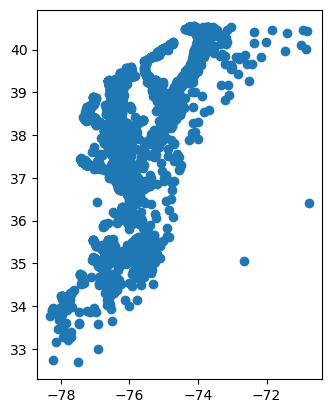

In [9]:
# ENC Wrecks gdf
ENC_gdf = read_kml(ENC_wrecks_kml_pth)
ENC_gdf.plot()


In [10]:
# Convert ENC gdf to refined df
ENC_df = create_refined_df(ENC_gdf)
ENC_df['description'] = 'ENC Wreck'
ENC_df

,lat,lon,size,description
0,39.214793,-76.586673,NaN,ENC Wreck
1,39.217762,-76.579224,NaN,ENC Wreck
2,39.206108,-76.582313,NaN,ENC Wreck
3,39.211635,-76.581251,NaN,ENC Wreck
4,39.183903,-76.580608,NaN,ENC Wreck
...,...,...,...,...
2490,33.393686,-77.878130,NaN,ENC Wreck
2491,33.405189,-77.712152,NaN,ENC Wreck
2492,33.393833,-77.878381,NaN,ENC Wreck
2493,33.283805,-77.831113,NaN,ENC Wreck


<AxesSubplot:>

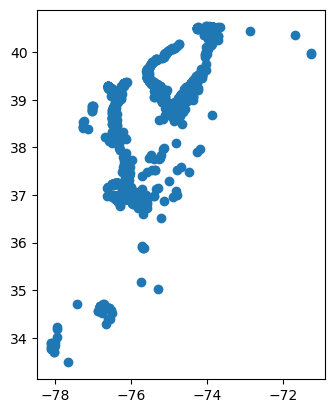

In [15]:
# AWOIS Wrecks gdf
AWOIS_gdf = read_kml(AWOIS_wrecks_kml_pth)
AWOIS_gdf.plot()

In [17]:
# AWOIS df
AWOIS_df = create_refined_df(AWOIS_gdf)
AWOIS_df['description'] = 'AWOIS Obstruction'
AWOIS_df


,lat,lon,size,description
0,38.820889,-76.471694,NaN,AWOIS Obstruction
1,38.823333,-76.439639,NaN,AWOIS Obstruction
2,37.962803,-74.175514,NaN,AWOIS Obstruction
3,39.073181,-76.516556,NaN,AWOIS Obstruction
4,38.093086,-74.811067,NaN,AWOIS Obstruction
...,...,...,...,...
1412,34.525164,-76.511586,NaN,AWOIS Obstruction
1413,34.582386,-76.538256,NaN,AWOIS Obstruction
1414,38.983719,-75.118203,NaN,AWOIS Obstruction
1415,40.042333,-74.986281,NaN,AWOIS Obstruction


In [20]:
# reef material
reef_gdf = read_kml(reef_kml_pth)
# reef_gdf = reef_gdf.clip((-78.317663,31.036502,-70.760165,40.541466))
reef_gdf

,Name,Description,geometry
0,Granite,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...","MULTIPOLYGON Z (((-76.45228 35.09324 0.00000, ..."
1,Granite,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...","MULTIPOLYGON Z (((-76.45232 35.09293 0.00000, ..."
2,Granite,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...","MULTIPOLYGON Z (((-76.45224 35.09274 0.00000, ..."
3,Granite,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...","MULTIPOLYGON Z (((-76.45246 35.09263 0.00000, ..."
4,Granite,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...","MULTIPOLYGON Z (((-76.45230 35.09245 0.00000, ..."
...,...,...,...
14339,Marl,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...","MULTIPOLYGON Z (((-76.45295 35.09328 0.00000, ..."
14340,Marl,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...","MULTIPOLYGON Z (((-76.45294 35.09318 0.00000, ..."
14341,Marl,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...","MULTIPOLYGON Z (((-76.45313 35.09353 0.00000, ..."
14342,Marl,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...","MULTIPOLYGON Z (((-76.45311 35.09367 0.00000, ..."


In [25]:
# TODO: Figure out why the fuck I cannot get the clipping to work.
reef_clip = gpd.clip(reef_gdf, (-78.317663,31.036502,-70.760165,40.541466))
reef_clip
# reproject to eastern US zone
# EPSG 
# Create reef dataframe
reef_df = pd.DataFrame(columns=['lat', 'lon', 'size', 'description', 'geometry'])
reef_df['lon'] = reef_clip.geometry.centroid.x
reef_df['lat'] = reef_clip.geometry.centroid.y
reef_df['description'] = reef_clip.Name
reef_df['geometry'] = reef_clip.geometry
reef_df

/var/folders/8m/cwkysk5d759d5nwvy056cdxw0000gn/T/ipykernel_19106/1631414360.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  reef_df['lon'] = reef_clip.geometry.centroid.x
/var/folders/8m/cwkysk5d759d5nwvy056cdxw0000gn/T/ipykernel_19106/1631414360.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  reef_df['lat'] = reef_clip.geometry.centroid.y


,lat,lon,size,description,geometry
13124,33.488332,-77.588079,NaN,Vessel,"POLYGON Z ((-77.58828 33.48846 0.00000, -77.58..."
13128,33.955444,-77.556013,NaN,Metal,"MULTIPOLYGON Z (((-77.55629 33.95489 0.00000, ..."
13126,33.957696,-77.557412,NaN,Vessel,"POLYGON Z ((-77.55744 33.95755 0.00000, -77.55..."
13125,33.960443,-77.556884,NaN,Vessel,"POLYGON Z ((-77.55716 33.96048 0.00000, -77.55..."
13127,33.960946,-77.553458,NaN,Vessel,"MULTIPOLYGON Z (((-77.55331 33.96054 0.00000, ..."
...,...,...,...,...,...
13280,36.003819,-75.530944,NaN,Reef Balls,"POLYGON Z ((-75.53094 36.00382 0.00000, -75.53..."
13270,36.003820,-75.530944,NaN,Reef Balls,"POLYGON Z ((-75.53095 36.00383 0.00000, -75.53..."
13250,36.003844,-75.530585,NaN,Metal,"POLYGON Z ((-75.53064 36.00386 0.00000, -75.53..."
13248,36.004101,-75.530902,NaN,Metal,"POLYGON Z ((-75.53092 36.00409 0.00000, -75.53..."


In [26]:
# TODO: Figoure out how to plot all these things on top of eachother